In [0]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, TimeSeriesSplit
from matplotlib import pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf 
import statsmodels.tsa.api as smt
from itertools import product                   
from tqdm import tqdm_notebook


In [0]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [0]:
from google.colab import files
files.upload()

Saving df_ads.pkl to df_ads.pkl


{'df_ads.pkl': b'\x1f\x8b\x08\x08I\x87\xec[\x02\xffdf_ads.pkl\x00u\xd8{\\M\xe9\x1e\xc7\xf1\xdd\x15\xe5\x96\x90D2E\t)B\xc8t\x11\x95T\x83\xa2\x90Z\xd5\xce\x8e\xdae\xefv\xd4\x14\x8dK\r\xad!Z\xe4hR\xee!Nf\\r\x8f\x91q\x0b19\x1a\xf7[C\x88\x93\x11\x99\xa1\xf3|\xf7\xef1\xaf\xc99\xa7?|\xda\x97\xf7Z\xcf\xb3\xf6Z{\xf5\xc8\xd0_\xb3\xb4\xa3L\xfb#\x9a$\n\xcahA\xed\x10\x95\xa0\x92;\xc4\xa8\x84x\xb9$\xb6\xf1\x12\x92\x84q\xda\xdfs\xa5~\xdfH\xe9\x92\x9dh\x10\x1e\xcd\x9e\x94\xc4.\x7f\x7f\x7f\xac2I\xaeR\nqjIl\xeb\x19\x97\x105\xc7_P\n\xb3\xe4*bva\xccuk\xf9\xfeh\xf9|\xb9\xda!RP\xb3\xdd\x18\x85+\xe5\xf3\xc2}\xf1\x1c\x03\nc\xd1\xe0\xd3\xef\xd8\xa1>\xdf\x9fR\x13\x9f\x98B<^\x13\x97\x14+\xa8TB\n\xdb_\xb8J\x1e\x95\xa0T\'\xa94QI\x8c\x88\x06\xda7Jb+\xb6;\xed[r%?\xd9Ri\x8cN\xa4\x94%M\x92\xec\xfct\xfct\x96J\x8a.\xa2AtRJ"f&\xea\x06\xba\xb0\xf7\xf8\xe9\xd0\xebz\xa2N\x9a\x14\x10\x100\xbe\x99\xfdh\xff\xf1sK\x92"\x97\x85I\xa2\x9eG\xb4Z\x12\xd8\x03Q_\x89\xa3\x12\xa0\xc9dD\xec\xf9\xbf\xe6\xc6\x86-O\x8a\x8d\x97\xb3c\xd2I;A/\

In [0]:
ads = pd.read_pickle('df_ads.pkl', 'gzip')

## Enfoque Econométrico 

Si un proceso es estacionario, eso significa que no cambia sus propiedades estadísticas a lo largo del tiempo, es decir, su media y varianza. (La constancia de la varianza se denomina homoscedasticidad) La función de covarianza no depende del tiempo; Sólo debería depender de la distancia entre las observaciones. 

<img src="est1.png" alt="drawing" width="600"/>
<img src="est2.png" alt="drawing" width="600"/>
<img src="est3.png" alt="drawing" width="600"/>

### Chart de ruido blanco

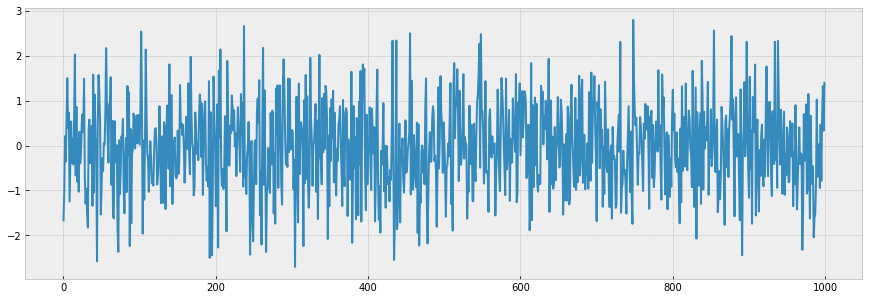

In [0]:
white_noise = np.random.normal(size=1000)
with plt.style.context('bmh'):  
    plt.figure(figsize=(15, 5))
    plt.plot(white_noise)

#### El proceso generado por la distribución normal estándar es estacionario y oscila alrededor de 0 con una desviación de 1. Ahora, en base a este proceso, generaremos uno nuevo donde cada valor subsiguiente dependerá del anterior: $x_t = ρ*x_{t-1} + e_t$

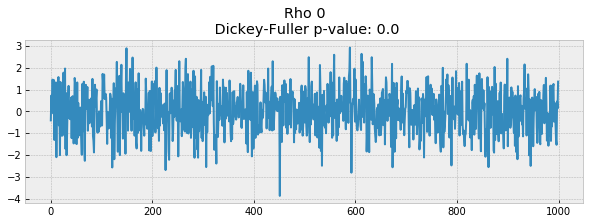

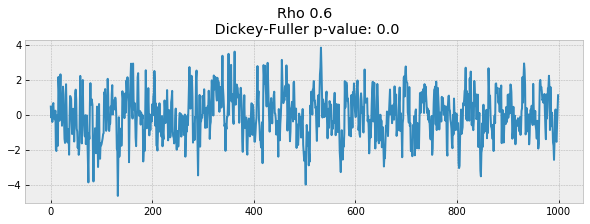

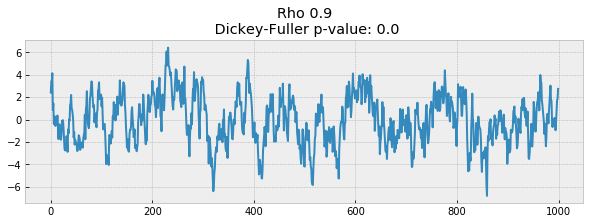

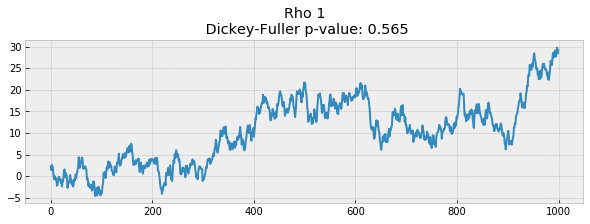

In [0]:
def plotProcess(n_samples=1000, rho=0):
    x = w = np.random.normal(size=n_samples)
    for t in range(n_samples):
        x[t] = rho * x[t-1] + w[t]

    with plt.style.context('bmh'):  
        plt.figure(figsize=(10, 3))
        plt.plot(x)
        plt.title("Rho {}\n Dickey-Fuller p-value: {}".format(rho, round(sm.tsa.stattools.adfuller(x)[1], 3)))
        
for rho in [0, 0.6, 0.9, 1]:
    plotProcess(rho=rho)


#### En el primer plot, podemos ver el mismo ruido blanco estacionario que antes. En el segundo plot con $ρ$ aumentada a 0,6, aparecieron ciclos más amplios, pero aún parece estacionario en general.El  tercer plot se desvía aún más de la media 0, pero todavía oscila sobre la media. Finalmente, con $ρ$ = 1, tenemos un proceso de recorrido aleatorio, es decir, una serie de tiempo no estacionaria.

#### Esto sucede porque, después de alcanzar el valor crítico, la serie $x_t = ρx_{t-1} + e_t$ no vuelve a su valor medio. Si restamos $x_{t-1}$ de ambos lados, obtendremos $x_t − x_{t-1} = (ρ − 1) x_{t-1} + e_t$, donde la expresión de la izquierda se conoce como la primera diferencia. 

#### Si $ρ = 1$, entonces la primera diferencia nos da un ruido blanco estacionario $e_t$. Esta es la idea principal detrás de la prueba de Dickey-Fuller para la estacionariedad de las series de tiempo (probar la presencia de una raíz unitaria). Si podemos obtener una serie estacionaria de una serie no estacionaria utilizando la primera diferencia, llamamos a esas series integradas de orden 1. La hipótesis nula de la prueba es que la serie temporal no es estacionaria, que se rechazó en los tres primeros. Parcelas y finalmente aceptadas en la última. Debemos decir que la primera diferencia no siempre es suficiente para obtener una serie estacionaria, ya que el proceso podría integrarse en el orden $d, d> 1$ (y tener múltiples raíces unitarias). En tales casos, se utiliza la prueba aumentada de Dickey-Fuller, que comprueba varios retrasos a la vez.

#### Podemos combatir la no estacionariedad utilizando diferentes enfoques:  varias diferencias de orden, eliminación de tendencias y estacionalidad, suavizado y transformaciones como Box-Cox o logarítmica.

#### Construyamos un modelo  ARIMA haciendo estacionaria la serie

/usr/local/lib/python3.6/dist-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


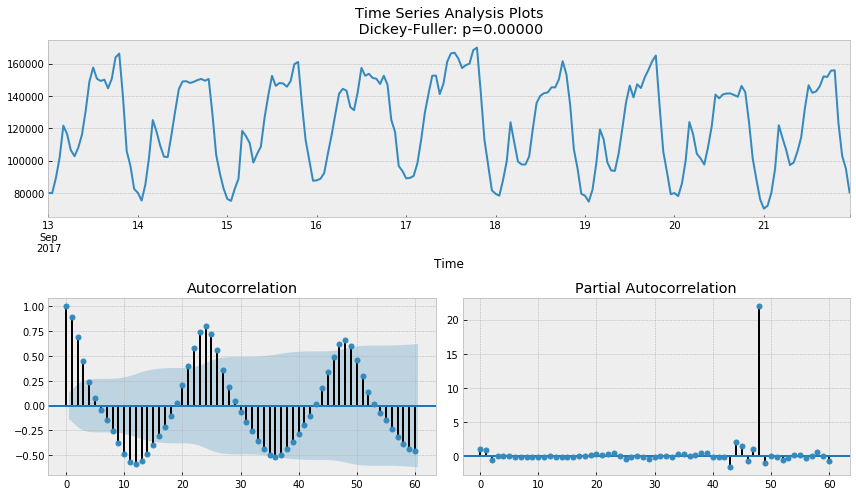

In [0]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        
        # definimos ejes
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        
        # obtengo el p-value con h0: raiz unitaria presente
        p_value = sm.tsa.stattools.adfuller(y)[1]
        
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        
        # plot de autocorrelacion
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        # plot de autocorrelacion parcial
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()
        
tsplot(ads.Ads, lags=60)

#### Sorprendentemente, las series iniciales son estacionarias; La prueba de Dickey-Fuller rechazó la hipótesis nula de que una raíz unitaria está presente. En realidad, podemos ver esto en los plot mismos: no tenemos una tendencia visible, por lo que la media es constante y la varianza es bastante estable. Lo único que queda es la estacionalidad, con la que tenemos que lidiar antes de modelar. Para hacerlo, tomemos la "diferencia estacional", que significa una simple resta de la serie de sí misma con un retraso que es igual al período estacional.

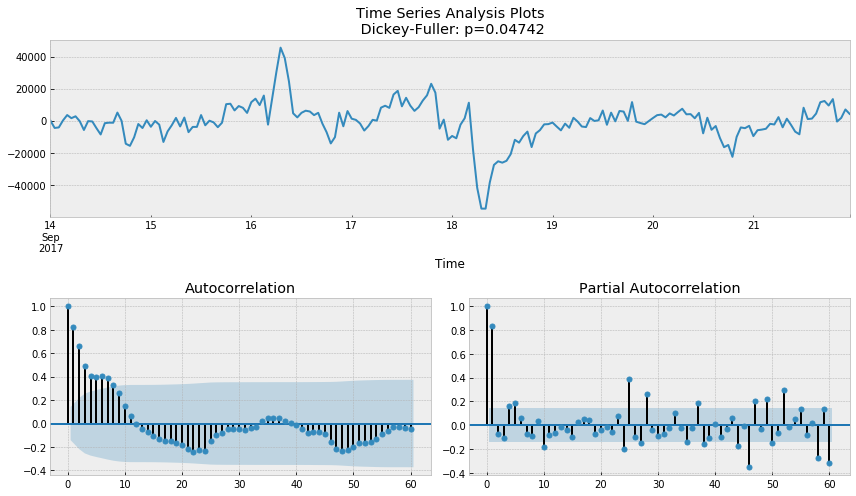

In [0]:
ads_diff = ads.Ads - ads.Ads.shift(24)
tsplot(ads_diff[24:], lags=60)

#### Ahora está mucho mejor con la estacionalidad visible desaparecida. Sin embargo, la función de autocorrelación todavía tiene demasiados rezagos significativos. Para eliminarlos, tomaremos las primeras diferencias, restando la serie de sí misma con el primer rezago. 

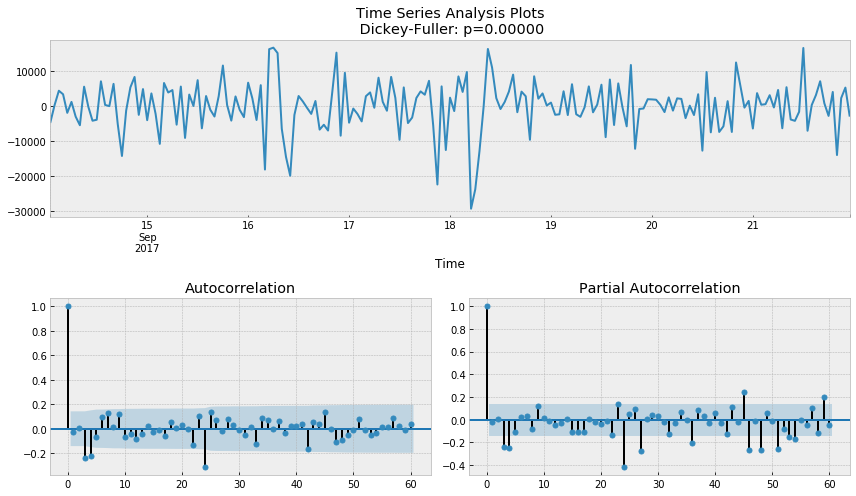

In [0]:
ads_diff = ads_diff - ads_diff.shift(1)
tsplot(ads_diff[24+1:], lags=60)

#### ¡Perfecto! Nuestra serie ahora parece algo indescriptible, oscilando alrededor de cero. La prueba de Dickey-Fuller indica que es estacionaria, y el número de picos significativos en ACF ha disminuido

## ARIMA
$SARIMA (p, d, q) (P, D, Q, s) $ Seasonal Autoregression Moving Average model

* AR (p) - modelo de autorregresión, es decir, regresión de la serie de tiempo sobre sí misma. El supuesto básico es que los valores de la serie actual dependen de sus valores anteriores con algún retraso (o varios retrasos). El máximo retraso en el modelo se conoce como $p$. Para determinar la $p$ inicial, debe mirar el gráfico PACF y encontrar el mayor rezago significativo, después de lo cual la mayoría de los demás retrasos se vuelven insignificantes.

* MA (q) - modelo de media móvil. Sin entrar en demasiados detalles, esto modela el error de la serie de tiempo, de nuevo con el supuesto de que el error actual depende de la anterior con un cierto rezago, que se conoce como $q$. El valor inicial se puede encontrar en el gráfico ACF con la misma lógica que antes.

$$AR(p)+MA(q)=ARMA(p,q)$$

Lo que tenemos hasta aquí es el  Autoregressive–moving-average model si la serie es estacionaria puede ser aproximado con estas 4 letras.

* I (d) - orden de integración. Esto es simplemente la cantidad de diferencias no estacionales necesarias para que la serie sea estacionaria. En nuestro caso, es solo 1 porque usamos las primeras diferencias. Agregar esta letra a lass cuatro nos da el modelo ARIMA que puede manejar datos no estacionarios con la ayuda de diferencias no estacionales.

* S (s): esto es responsable de la estacionalidad y es igual a la duración del período de temporada de la serie

Con esto, tenemos tres parámetros: (P, D, Q)
* P: orden de autorregresión para el componente estacional del modelo, que puede derivarse de PACF. Pero hay que mirar el número de retrasos significativos, que son los múltiplos de la duración del período de la temporada. Por ejemplo, si el período es igual a 24 y vemos que los desfases 24 y 48 son significativos en el PACF, eso significa que la P inicial debe ser 2.

* Q- lógica similar usando el gráfico ACF en su lugar.

* D - orden de integración estacional. Esto puede ser igual a 1 o 0, dependiendo de si las diferencias estacionales se aplicaron o no.

Ahora que sabemos cómo configurar los parámetros iniciales, echemos un vistazo a la gráfica final una vez más y establezcamos los parámetros:

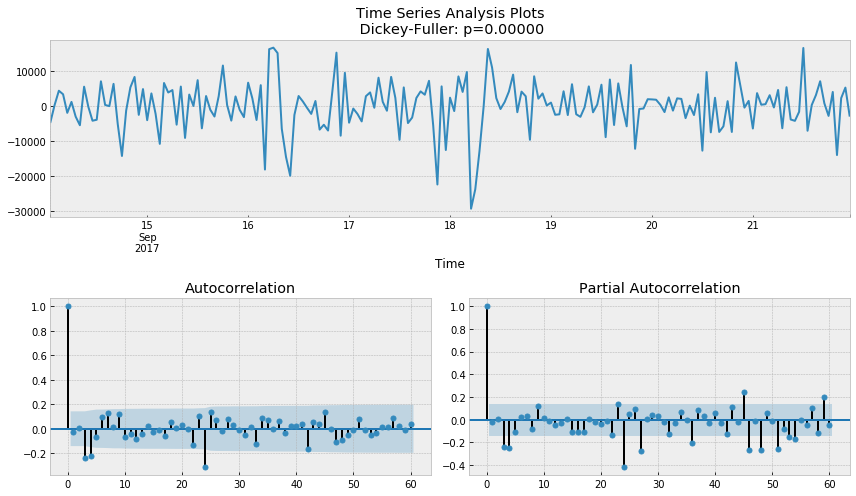

In [0]:
tsplot(ads_diff[24+1:], lags=60)

*  $p$ es más probable que sea 4 ya que es el último retraso significativo en el PACF, después del cual, la mayoría de los otros no son significativos.
* $d$ es igual a 1 porque teníamos primeras diferencias
* $q$ debería estar en algún lugar alrededor de 4, como se ve en la ACF
* $P$ podría ser 2, ya que los retrasos 24 y 48 son algo significativos en el PACF
* $D$ de nuevo es igual a 1 porque realizamos diferenciación estacional
* $Q$ es probablemente 1. El rezago 24-en ACF es significativo, mientras que el 48-no lo es.
Probemos varios modelos y veamos cuál es mejor.

In [0]:
ps = range(2, 5)
d=1 
qs = range(2, 5)
Ps = range(0, 3)
D=1 
Qs = range(0, 2)
# season = 24
s = 24 

# productoria
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

54

In [0]:
def optimizeSARIMA(parameters_list, d, D, s):
    """
        Return dataframe with parameters and corresponding AIC
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order in ARIMA model
        D - seasonal integration order 
        s - length of season
    """
    
    results = []
    best_aic = float("inf")

    for param in tqdm_notebook(parameters_list):
        # hacemos try except porque algunas combinaciones no convergen
        try:
            model=sm.tsa.statespace.SARIMAX(ads.Ads, 
                                            order=(param[0], d, param[1]), 
                                            seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
        
        aic = model.aic
        # akeike
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        #guardamos todos los parametros dado un aic
        results.append([param, model.aic])

    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    #  bajo aic es mejor
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table


In [0]:
%%time
result_table = optimizeSARIMA(parameters_list, d, D, s)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packa


CPU times: user 19min 41s, sys: 9min 24s, total: 29min 5s
Wall time: 14min 36s


In [0]:
result_table.head()

,parameters,aic
0,"(2, 3, 1, 1)",3888.642174
1,"(3, 2, 1, 1)",3888.763568
2,"(3, 2, 2, 1)",3889.705536
3,"(2, 3, 2, 1)",3889.717128
4,"(4, 2, 1, 1)",3890.279740


In [0]:
# seleccionamos los parámetros
p, q, P, Q = result_table.parameters[0]

best_model=sm.tsa.statespace.SARIMAX( ads.Ads, order=(p, d, q), 
                                      seasonal_order=(P, D, Q, s)).fit(disp=-1)
print(best_model.summary())

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


                                 Statespace Model Results                                 
Dep. Variable:                                Ads   No. Observations:                  216
Model:             SARIMAX(2, 1, 3)x(1, 1, 1, 24)   Log Likelihood               -1936.321
Date:                            Thu, 21 Nov 2019   AIC                           3888.642
Time:                                    21:50:08   BIC                           3914.660
Sample:                                09-13-2017   HQIC                          3899.181
                                     - 09-21-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7913      0.270      2.928      0.003       0.262       1.321
ar.L2         -0.5503      0.306   

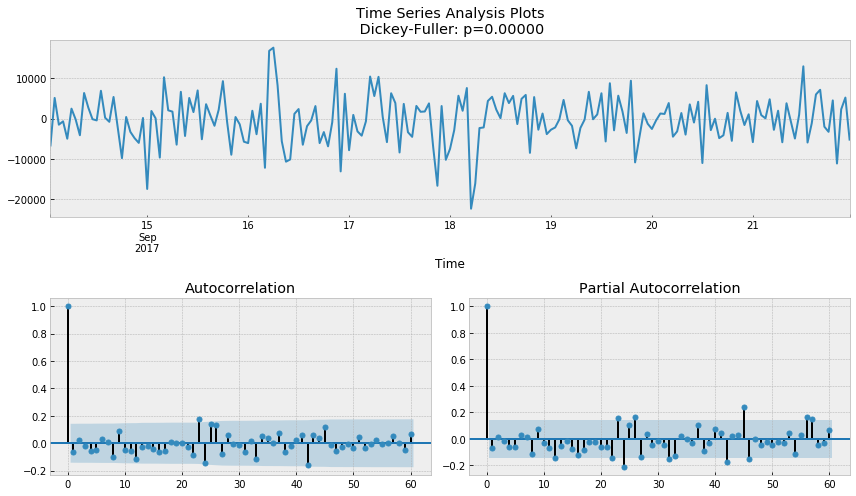

In [0]:
tsplot(best_model.resid[24+1:], lags=60)

Está claro que los residuos son estacionarios y no hay autocorrelaciones aparentes. Hagamos predicciones usando nuestro modelo.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


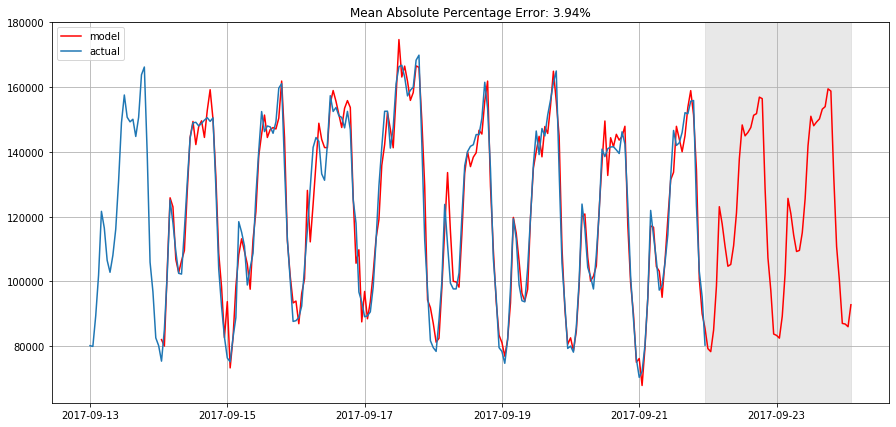

In [0]:
def plotSARIMA(series, model, n_steps):
    """
        Plots model vs predichos
        
        series - dataset con series de tiempo
        model - SARIMA model ya entrenado
        n_steps - cantidad de predicciones futuras
        
    """
    # adding model values
    data = series.copy()
    data.columns = ['actual']
    data['arima_model'] = model.fittedvalues
    
    # sacamos con operaciones sobre los indices para que no sean vistos por el modelo
    data['arima_model'][:s+d] = np.NaN
    
    # predecimos
    forecast = model.predict(start = data.shape[0], end = data.shape[0]+n_steps)
    forecast = data.arima_model.append(forecast)
    #computamos el error
    error = mean_absolute_percentage_error(data['actual'][s+d:], data['arima_model'][s+d:])

    plt.figure(figsize=(15, 7))
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
    plt.plot(forecast, color='r', label="model")
    plt.axvspan(data.index[-1], forecast.index[-1], alpha=0.5, color='lightgrey')
    plt.plot(data.actual, label="actual")
    plt.legend()
    plt.grid(True);
    
plotSARIMA(ads, best_model, 50)

## Series de tiempo: Modelos no lineales


In [0]:
data = pd.DataFrame(ads.Ads.copy())
data.columns = ["y"]


for i in range(6, 25):
    data["lag_{}".format(i)] = data.y.shift(i)

In [0]:

# hacemos un cross val para series de tiempo 
tscv = TimeSeriesSplit(n_splits=5)

def timeseries_train_test_split(X, y, test_size):
    """
        train test segun un esquema para series de tiempo
    """
    
    # tomamos el indice en donde empieza el test
    test_index = int(len(X)*(1-test_size))
    
    X_train = X.iloc[:test_index]
    y_train = y.iloc[:test_index]
    
    X_test = X.iloc[test_index:]
    y_test = y.iloc[test_index:]
    
    return X_train, X_test, y_train, y_test

def plotModelResults(model, X_train, X_test, plot_intervals=False, plot_anomalies=False):
    """
        graficamos verdaderos, predichos, intervalos de confianza y anomalias 
    
    """
    
    prediction = model.predict(X_test)
    
    plt.figure(figsize=(15, 7))
    plt.plot(prediction, "g", label="prediction", linewidth=2.0)
    plt.plot(y_test.values, label="actual", linewidth=2.0)
    
    if plot_intervals:
        cv = cross_val_score(model, 
                             X_train, 
                             y_train,                                    
                             cv = tscv,
                             scoring="neg_mean_absolute_error")
        
        mae = cv.mean() * (-1)
        deviation = cv.std()
        
        scale = 1.96
        lower = prediction - (mae + scale * deviation)
        upper = prediction + (mae + scale * deviation)
        
        plt.plot(lower, "r--", label="upper bond / lower bond", alpha=0.5)
        plt.plot(upper, "r--", alpha=0.5)
        
        if plot_anomalies:
            anomalies = np.array([np.NaN]*len(y_test))
            anomalies[y_test<lower] = y_test[y_test<lower]
            anomalies[y_test>upper] = y_test[y_test>upper]
            plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    error = mean_absolute_percentage_error(prediction, y_test)
    plt.title("Mean absolute percentage error {0:.2f}%".format(error))
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True);
    
def plotCoefficients(model):
    """
        Plots sorted coefficient values of the model
    """
    
    coefs = pd.DataFrame(model.coef_, X_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)
    
    plt.figure(figsize=(15, 7))
    coefs.coef.plot(kind='bar')
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed');
    
    


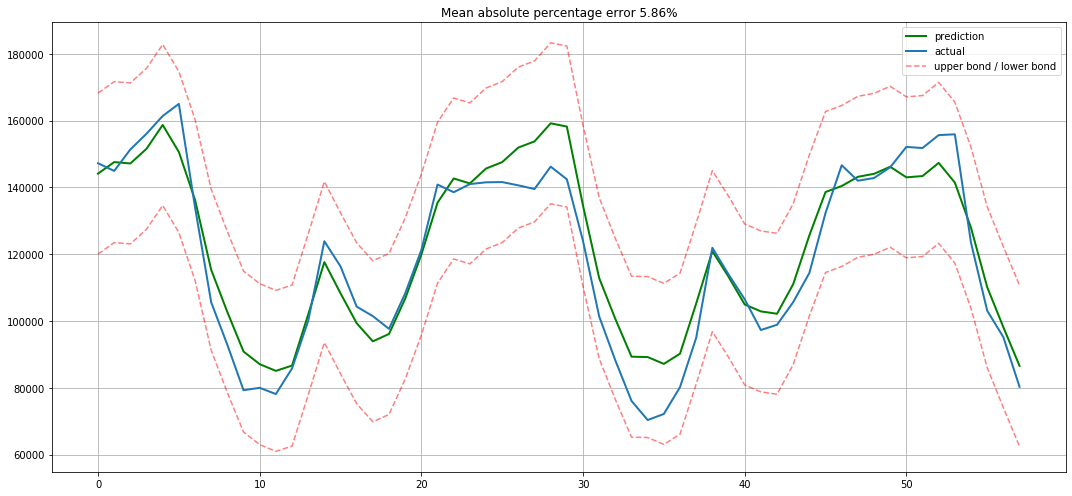

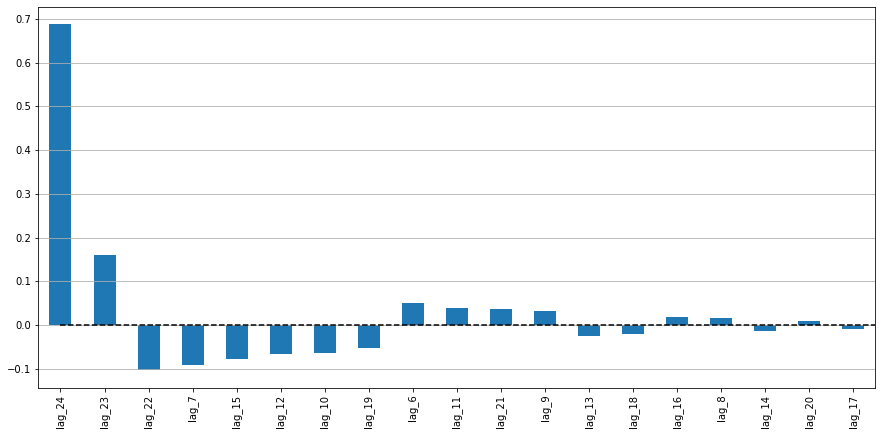

In [0]:
y = data.dropna().y
X = data.dropna().drop(['y'], axis=1)


X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.3)


lr = LinearRegression()
lr.fit(X_train, y_train)

plotModelResults(lr, X_train=X_train, X_test=X_test,  plot_anomalies=False, plot_intervals=True)
plotCoefficients(lr)

In [0]:
data.index = data.index.to_pydatetime()
data["hour"] = data.index.hour
data["weekday"] = data.index.weekday
data['is_weekend'] = data.weekday.isin([5,6])*1

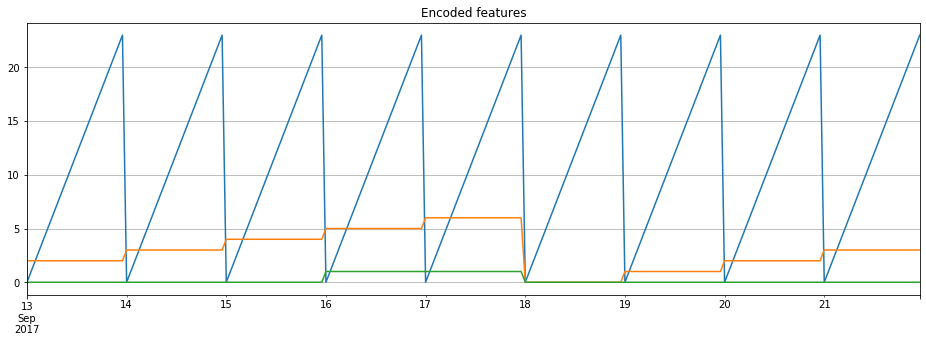

In [0]:
plt.figure(figsize=(16, 5))
plt.title("Encoded features")
data.hour.plot()
data.weekday.plot()
data.is_weekend.plot()
plt.grid(True);

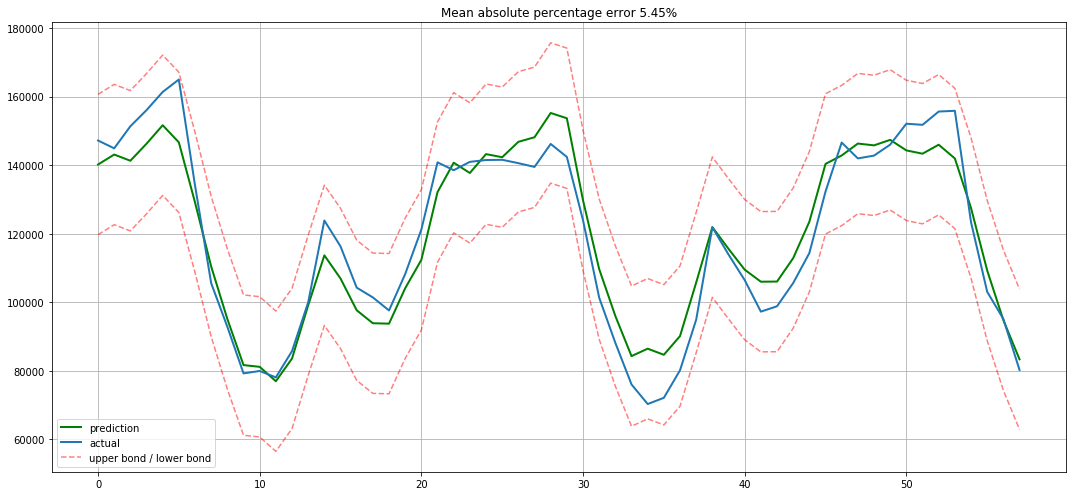

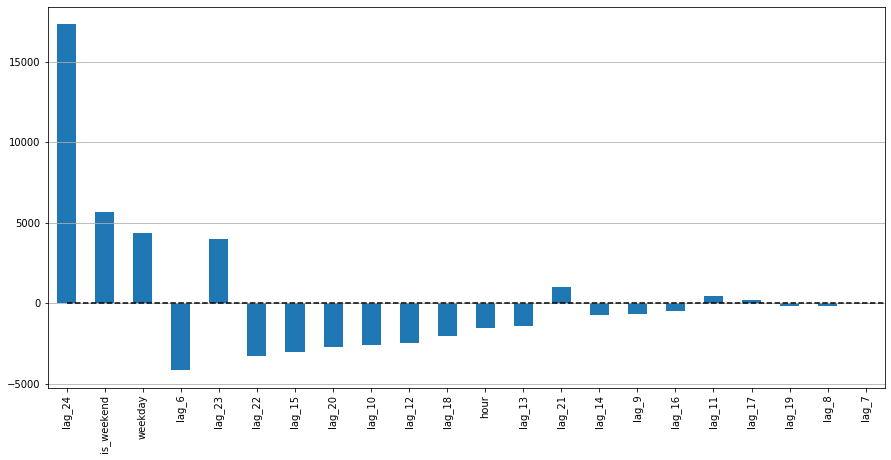

In [0]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

y = data.dropna().y
X = data.dropna().drop(['y'], axis=1)

X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.3)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

plotModelResults(lr, X_train=X_train_scaled, X_test=X_test_scaled, plot_intervals=True)
plotCoefficients(lr)

In [0]:
def code_mean(data, cat_feature, real_feature):
    """
    the devuelve un diccionario donde las keys son categorias unicas de cat_feature,
    y los valores son las verdaderas medias.
    """
    return dict(data.groupby(cat_feature)[real_feature].mean())

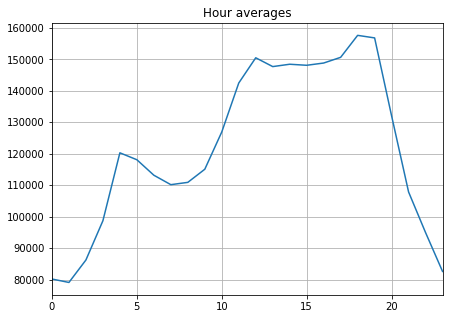

In [0]:
average_hour = code_mean(data, 'hour', "y")
plt.figure(figsize=(7, 5))
plt.title("Hour averages")
pd.DataFrame.from_dict(average_hour, orient='index')[0].plot()
plt.grid(True);

In [0]:
def prepareData(series, lag_start, lag_end, test_size, target_encoding=False):
    """
        series: pd.DataFrame
            dataframe con timeseries
        lag_start: int
            Cota superior de la ventana
            ejemplo - lag_start = 1 
            ve hasta ayer los valores mas cercanos para prediccion.
        lag_end: int
            cota inferior de la ventana
            ejemplo - lag_end = 4 lo mas lejano que ve el modelo es 
            4 dias atras
        test_size: float
            porcentaje del dataset para test (1 es todo, 0 nada)
        target_encoding: booleano
            if True - agrega las medias del target
        
    """
    data = pd.DataFrame(series.copy())
    data.columns = ["y"]
    
    # lags de la serie
    for i in range(lag_start, lag_end):
        data["lag_{}".format(i)] = data.y.shift(i)
    
    # datetime features
    data.index = data.index.to_pydatetime()
    data["hour"] = data.index.hour
    data["weekday"] = data.index.weekday
    data['is_weekend'] = data.weekday.isin([5,6])*1
    
    if target_encoding:
        # calcula promedios en test
        test_index = int(len(data.dropna())*(1-test_size))
        data['weekday_average'] = list(map(
            code_mean(data[:test_index], 'weekday', "y").get, data.weekday))
        data["hour_average"] = list(map(
            code_mean(data[:test_index], 'hour', "y").get, data.hour))

        # drop encoded variables 
        data.drop(["hour", "weekday"], axis=1, inplace=True)
    
    # train-test split
    y = data.dropna().y
    X = data.dropna().drop(['y'], axis=1)
    X_train, X_test, y_train, y_test =\
    timeseries_train_test_split(X, y, test_size=test_size)

    return X_train, X_test, y_train, y_test



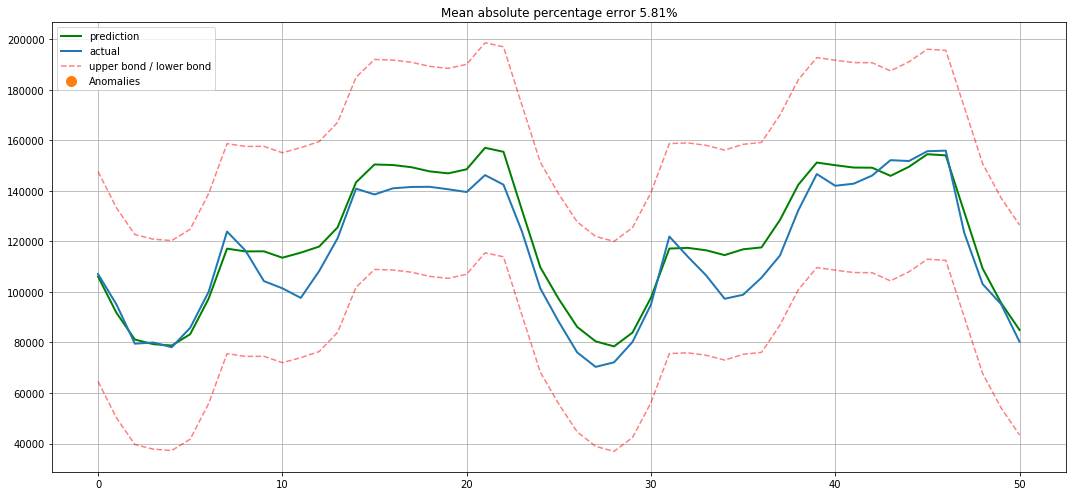

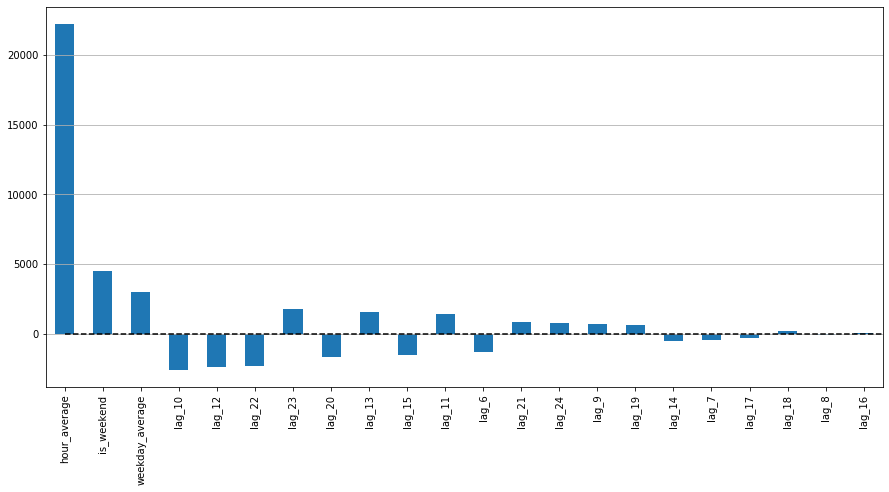

In [0]:
X_train, X_test, y_train, y_test = prepareData(ads.Ads, lag_start=6, lag_end=25, test_size=0.3, target_encoding=True)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

plotModelResults(lr, X_train=X_train_scaled, X_test=X_test_scaled, 
                 plot_intervals=True, plot_anomalies=True)
plotCoefficients(lr)

In [0]:
X_train, X_test, y_train, y_test =\
prepareData(ads.Ads, lag_start=6, lag_end=25, test_size=0.3, target_encoding=False)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

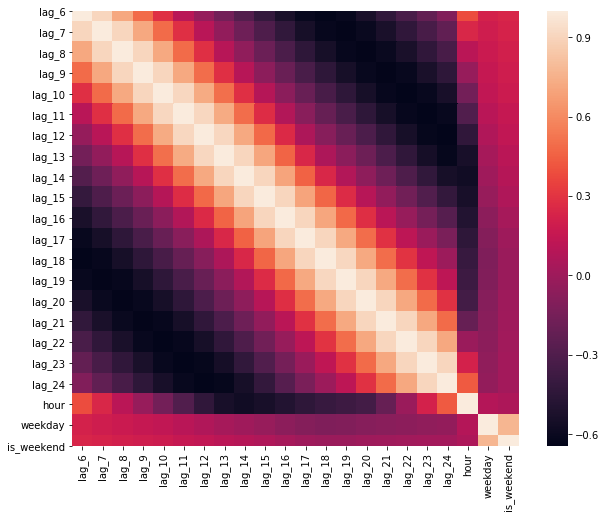

In [0]:
plt.figure(figsize=(10, 8))
sns.heatmap(X_train.corr());

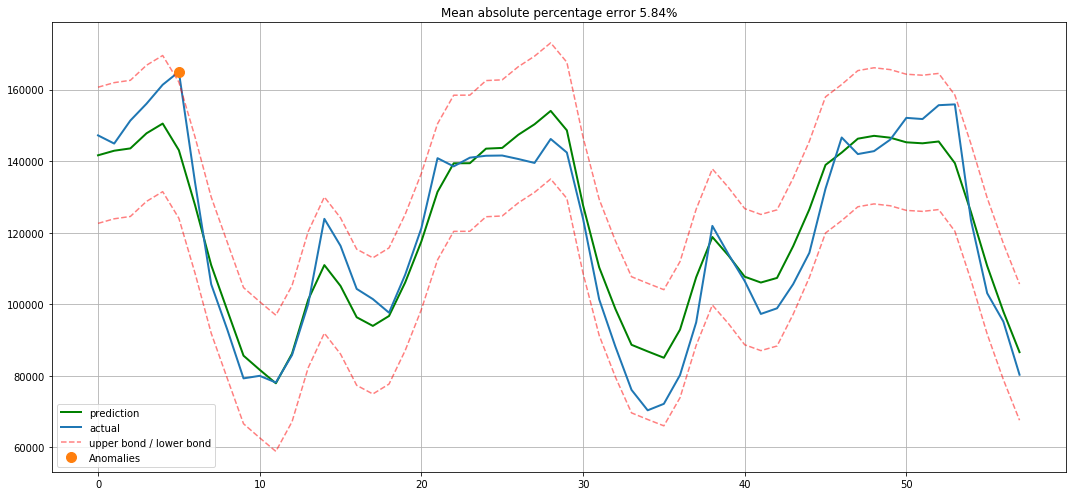

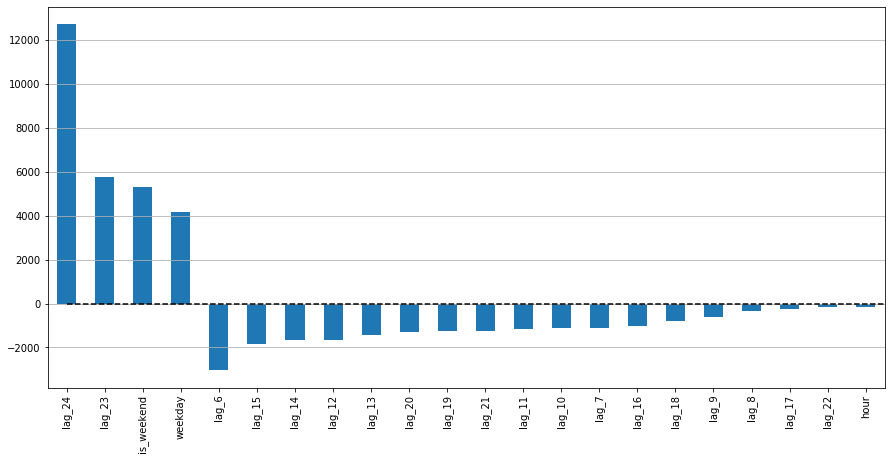

In [0]:
from sklearn.linear_model import LassoCV, RidgeCV

ridge = RidgeCV(cv=tscv)
ridge.fit(X_train_scaled, y_train)

plotModelResults(ridge, 
                 X_train=X_train_scaled, 
                 X_test=X_test_scaled, 
                 plot_intervals=True, plot_anomalies=True)
plotCoefficients(ridge)

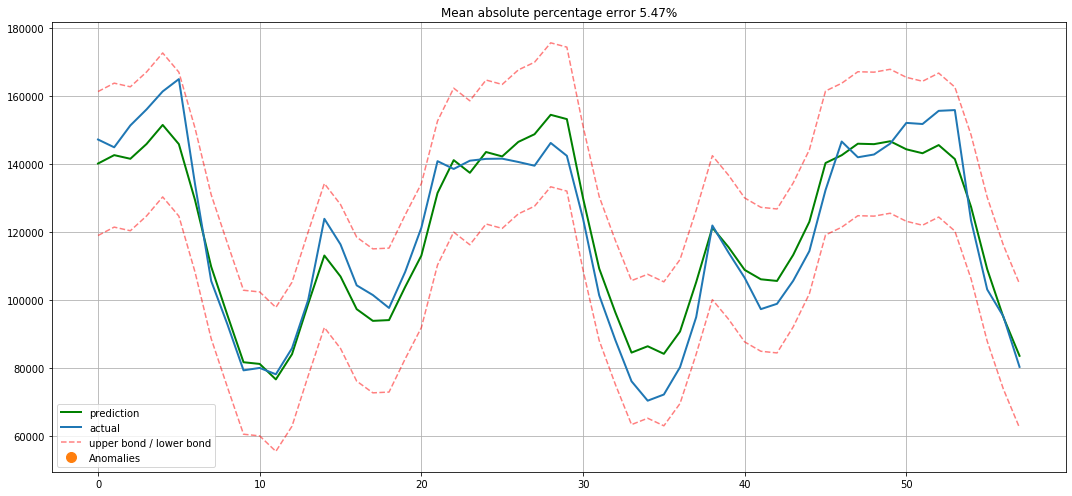

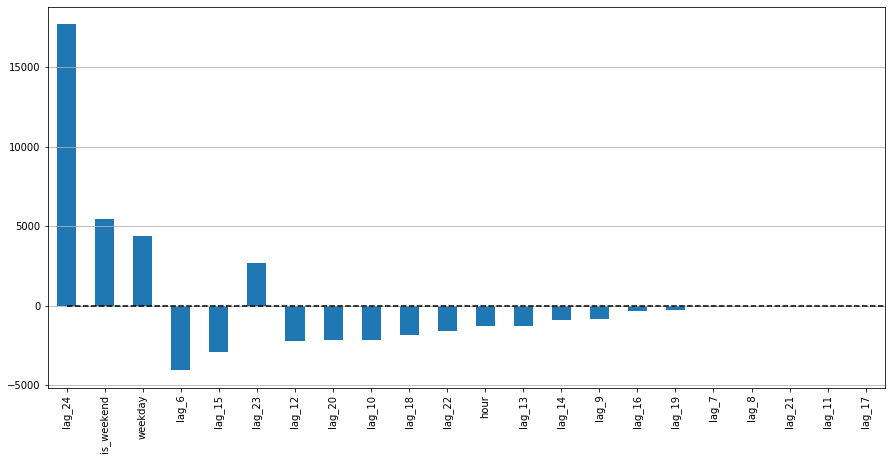

In [0]:
lasso = LassoCV(cv=tscv)
lasso.fit(X_train_scaled, y_train)

plotModelResults(lasso, 
                 X_train=X_train_scaled, 
                 X_test=X_test_scaled, 
                 plot_intervals=True, plot_anomalies=True)
plotCoefficients(lasso)

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[21:50:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:50:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:50:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:50:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:50:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:50:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


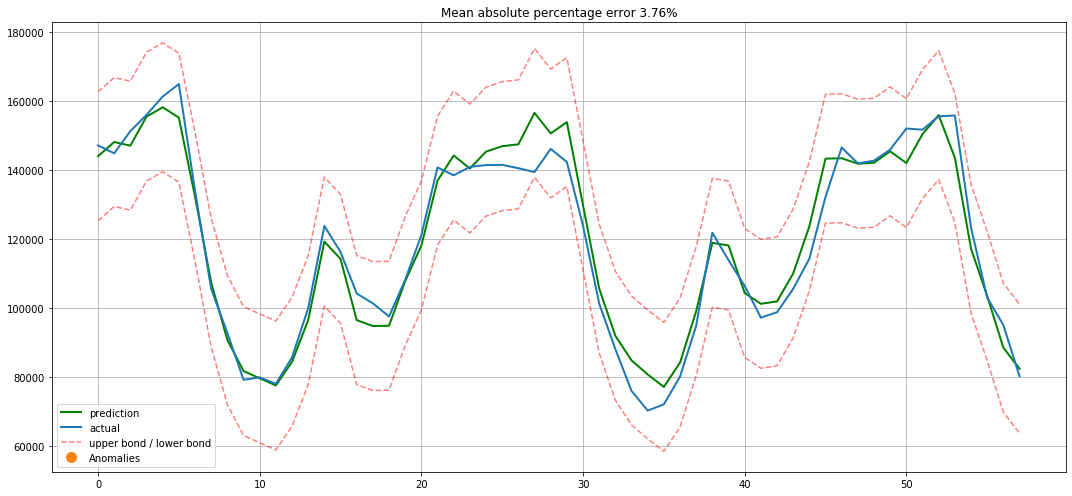

In [0]:
from xgboost import XGBRegressor 

xgb = XGBRegressor()
xgb.fit(X_train_scaled, y_train)

plotModelResults(xgb, 
                 X_train=X_train_scaled, 
                 X_test=X_test_scaled, 
                 plot_intervals=True, plot_anomalies=True)